In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import os
from albumentations.pytorch import ToTensorV2
import pandas as pd
from torchvision import datasets
import torch
import albumentations as A
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
class ChannelReducer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ChannelReducer, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        return self.conv(x)

In [3]:
def create_canny_images(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert image to grayscale
    blurred = cv2.GaussianBlur(grayscale, (5,5), 0) # apply Gaussian blur
    canny = cv2.Canny(blurred, 30, 150)
    return canny

In [4]:
device = torch.device("mps")

In [5]:
class GTSRBDataset(datasets.ImageFolder):
    def __init__(self, csv_file, img_dir, transform=None, canny_transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.canny_transform = canny_transform
        self.class_to_idx = {int(row['ClassId']): row['Path'].split('/')[0] for _, row in self.csv_data.iterrows()}

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.csv_data.iloc[index]['Path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imagecanny = cv2.GaussianBlur(image, (5,5), 0) # apply Gaussian blur
        imagecanny = cv2.Canny(imagecanny, 30, 150)
        # label = int(self.csv_data.iloc[index]['ClassId'])
        # label = image

        if self.transform:
            transformed = self.transform(image=image)['image']
            
            canny_image = imagecanny.reshape((imagecanny.shape[0], imagecanny.shape[1], -1))
            canny_image = self.canny_transform(image=canny_image)['image']
            canny_image = torch.from_numpy(canny_image)
            canny_image = canny_image.permute(2, 0, 1)
            concatenated_image = torch.cat([transformed, canny_image], dim=0)

        return concatenated_image, transformed

# Defined transformations
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

canny_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.485],
            std=[0.229]
        )])

base_dir = "../gtsrb-german-traffic-sign"  # Adjust this path as necessary
train_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Train.csv'), img_dir=base_dir, transform=transform, canny_transform=canny_transform)

train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [train_size, valid_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [6]:
net = ChannelReducer(4, 3, 3)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
criterion = nn.MSELoss()

In [7]:

for epoch in range(5):  
    pbar = tqdm(train_loader, desc="Training", unit="batch")
    val = tqdm(valid_loader, desc="Validation", unit="batch")
    running_loss = 0.0
    i = 0
    
    for inputs, labels in pbar:
        i+=1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # #Validation 
    #     for inputs, labels in val:
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs = net(inputs)
    #         valloss = criterion(outputs, labels)
            
    print(f"Training Loss is: {loss.item()}")
    #print(f"Validation Loss: {valloss.item()}")
            
print('Finished Training')


torch.save(net.state_dict(), 'round2.pth')


Training: 100%|██████████| 307/307 [00:39<00:00,  7.81batch/s]


Training Loss is: 0.03844873234629631


Training: 100%|██████████| 307/307 [00:39<00:00,  7.80batch/s]


Training Loss is: 0.021513167768716812


Training: 100%|██████████| 307/307 [00:39<00:00,  7.75batch/s]


Training Loss is: 0.01315287034958601


Training: 100%|██████████| 307/307 [00:40<00:00,  7.60batch/s]


Training Loss is: 0.009270074777305126


Training: 100%|██████████| 307/307 [00:40<00:00,  7.51batch/s]

Training Loss is: 0.006146817468106747
Finished Training


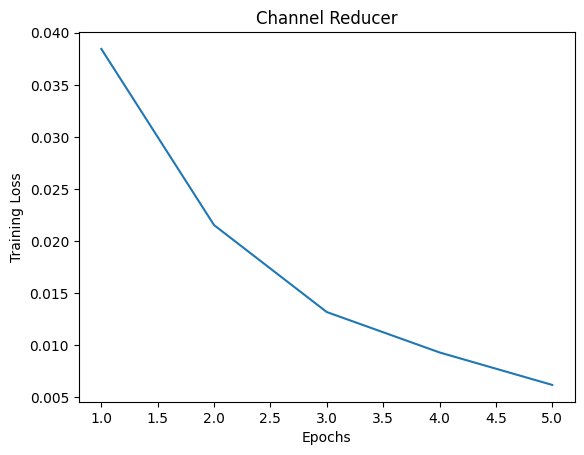

In [9]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y = [0.03844873234629631, 0.021513167768716812, 0.01315287034958601, 0.009270074777305126, 0.006146817468106747]

# Plotting the data
plt.plot(x, y)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Channel Reducer')

# Displaying the plot
plt.show()
